In [1]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from PIL import Image

import copy

## Image selection

In [2]:
image_path, image_name = './pipes.jpg', 'pipes'
# image_path, image_name = './chess-board.jpg', 'chess_board'

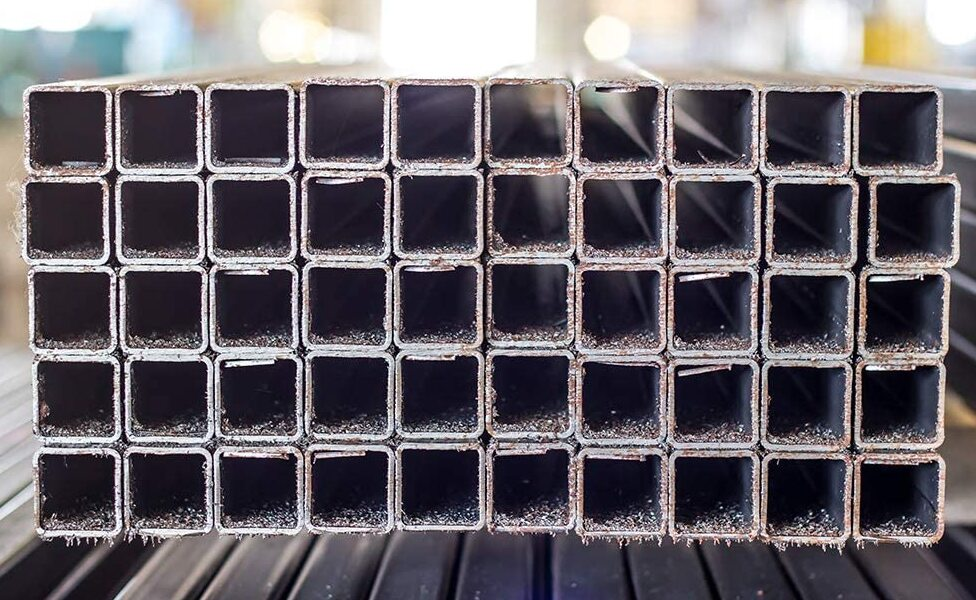

In [3]:
raw_image = Image.open(image_path)
raw_image

# Canny edge detection

## 1. Rescale

In [4]:
image = np.array(raw_image) / 255.
image.shape

(600, 976, 3)

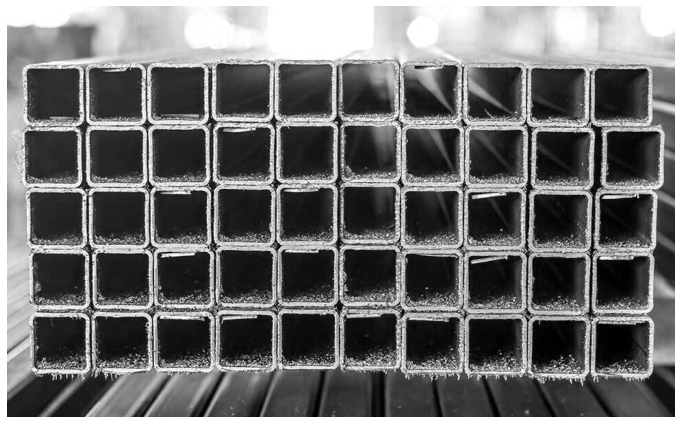

In [5]:
def show_and_save(image, save_name=None, show=True):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(image, cmap='gray')
    if save_name:
        plt.savefig(f'./plots/{save_name}.jpg')
    if show:
        plt.show()
    
show_and_save(image[:, :, 0])

## 2. RGB → grayscale

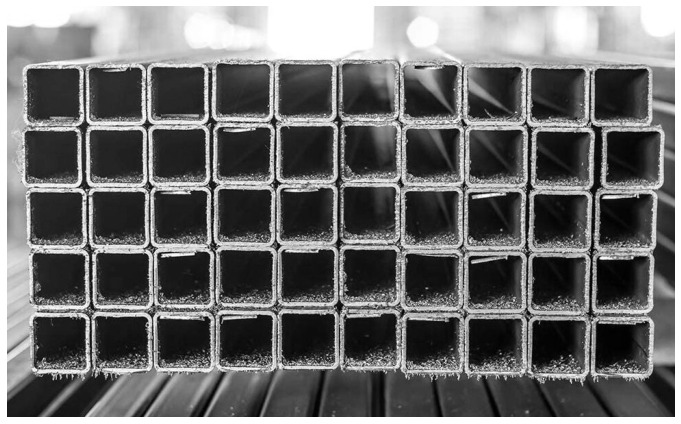

In [6]:
rgb_to_gray_kernel = (0.5, 0.3, 0.2)

rgb_to_gray_conv = tf.keras.layers.Conv2D(1, (1, 1), 
                                          strides=(1, 1), 
                                          padding='valid',
                                          kernel_initializer=tf.keras.initializers.Constant(rgb_to_gray_kernel))
gray_image = rgb_to_gray_conv(np.array([image]))[0]
show_and_save(gray_image, 'grayscale_image')

## 3. Gaussian blur

In [7]:
N_BLUR = 9
SIGMA = 3.5

In [8]:
def gaussian_kernel(size, sigma=1):
    size = size // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    kernel = np.exp(-(np.square(x) + np.square(y)) / (2. * np.square(sigma)))
    kernel /= 2. * np.pi * np.square(sigma)
    return (kernel / np.sum(kernel))

gaussian_kernel(3)

array([[0.07511361, 0.1238414 , 0.07511361],
       [0.1238414 , 0.20417996, 0.1238414 ],
       [0.07511361, 0.1238414 , 0.07511361]])

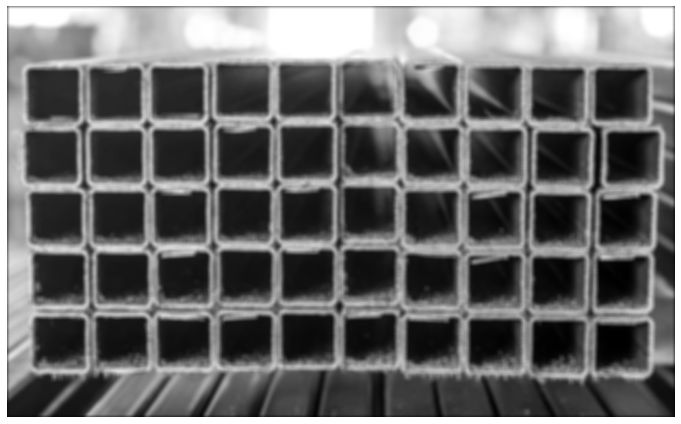

In [9]:
blur_conv = tf.keras.layers.Conv2D(1, (N_BLUR, N_BLUR),
                                   strides=(1, 1),
                                   padding='same',
                                   kernel_initializer=tf.keras.initializers.Constant(gaussian_kernel(N_BLUR, sigma=SIGMA)))
blurred_image = blur_conv(np.array([gray_image]))[0]
show_and_save(blurred_image, 'blurred_image')

## 4. Gradient

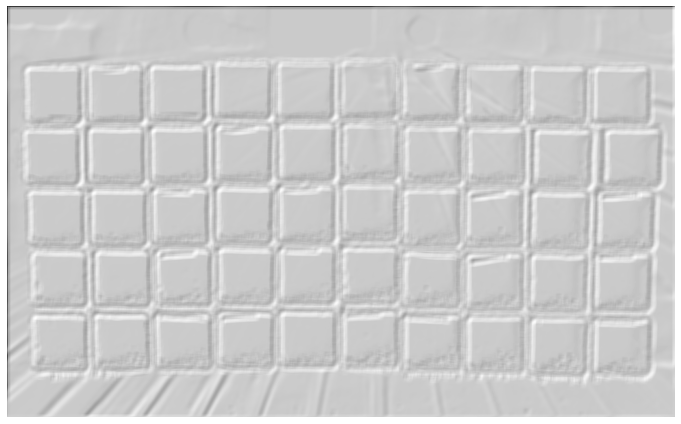

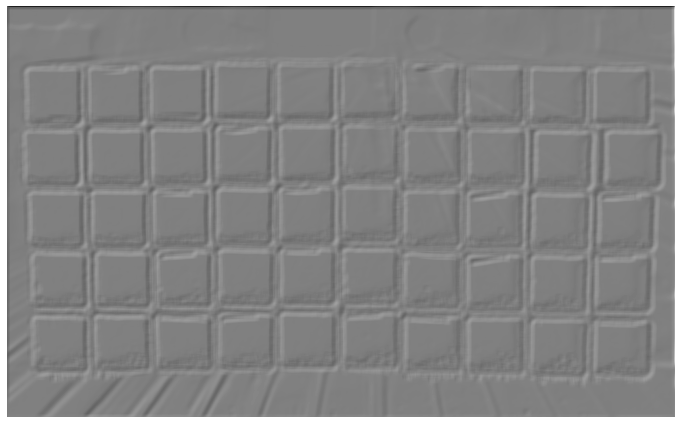

In [10]:
sobel_kernel = np.array([
    [[1, 2, 1],
     [0, 0, 0],
     [-1, -2, -1]],
    [[1, 0, -1],
     [2, 0, -2],
     [1, 0, -1]]
])
sobel_conv = tf.keras.layers.Conv2D(2, (3, 3),
                                   strides=(1, 1),
                                   padding='same',
                                   kernel_initializer=tf.keras.initializers.Constant(sobel_kernel))
gradients = sobel_conv(np.array([blurred_image]))[0]
x_grad, y_grad = gradients[:, :, 0], gradients[:, :, 1]
show_and_save(x_grad, 'x_gradient')
show_and_save(y_grad, 'y_gradient')

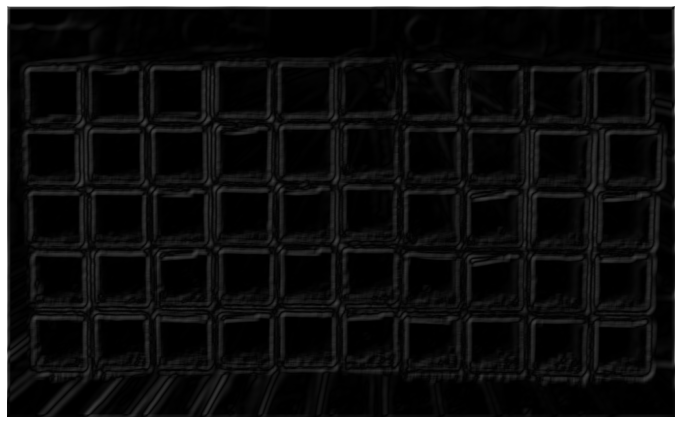

(0.0, 1.6149598)

In [11]:
grad_length = np.sqrt(np.square(x_grad) + np.square(y_grad))
show_and_save(grad_length, 'gradient_length')
np.min(grad_length), np.max(grad_length)

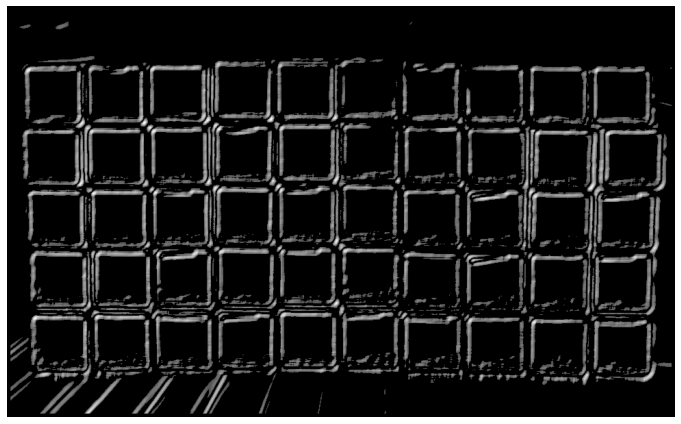

In [12]:
edges = np.zeros(shape=grad_length.shape)
edges[5:-5, 5:-5] = grad_length[5:-5, 5:-5]
edges /= np.max(edges)
edges = tf.keras.activations.relu(edges, threshold=0.3)
show_and_save(edges, 'fixed_edges_after_relu')

# Hough transform

## 1. Max pooling

In [13]:
DOWNSCALING_FACTOR = 4

assert edges.shape[0] % DOWNSCALING_FACTOR == 0
assert edges.shape[1] % DOWNSCALING_FACTOR == 0

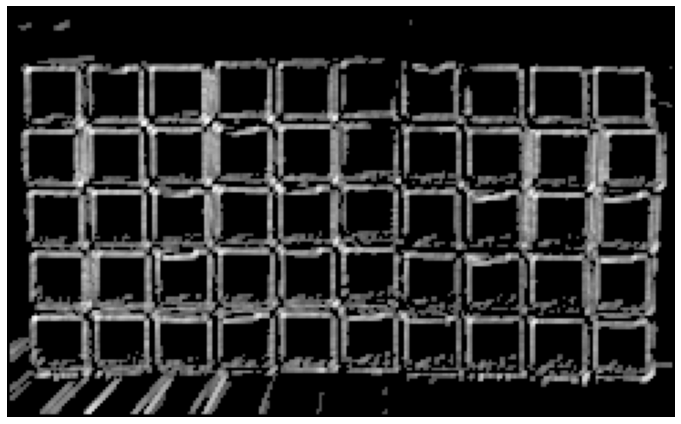

TensorShape([150, 244, 1])

In [14]:
max_pool = tf.keras.layers.MaxPooling2D(pool_size=(DOWNSCALING_FACTOR, DOWNSCALING_FACTOR), padding='same')
downscaled_edges = max_pool(tf.reshape(edges, [1, *edges.shape, 1]))[0]
show_and_save(downscaled_edges)
downscaled_edges.shape

## 2. Voting

In [15]:
START_KERNEL_SIZE = 40 // DOWNSCALING_FACTOR
END_KERNEL_SIZE = 160 // DOWNSCALING_FACTOR

In [16]:
def square_kernel(size, normalize=False):
    kernel = np.ones(shape=(size, size))
    if normalize:
        kernel /= size
    kernel[1:-1, 1:-1] = np.zeros(shape=(size-2, size-2))
    return kernel
    
square_kernel(5)

array([[1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1.]])

In [17]:
def get_square_kernels(start_size, end_size, normalize=False):
    kernels = []
    for size in range(start_size, end_size + 1):
        kernels += [square_kernel(size, normalize)]
    return kernels

get_square_kernels(5, 15)[10].shape

(15, 15)

In [18]:
hough_space = []
for kernel in get_square_kernels(START_KERNEL_SIZE, END_KERNEL_SIZE, normalize=True):
    transpose_conv = tf.keras.layers.Conv2DTranspose(1, kernel.shape,
                                                     strides=(1, 1),
                                                     padding='same',
                                                     kernel_initializer=tf.keras.initializers.Constant(kernel))
    current_hough_space = transpose_conv(np.array([downscaled_edges]))[0]
    hough_space += [current_hough_space]
    show_and_save(current_hough_space, f'hough_space/hough_space_{kernel.shape[0]}', show=False)
    plt.clf()

<Figure size 720x432 with 0 Axes>

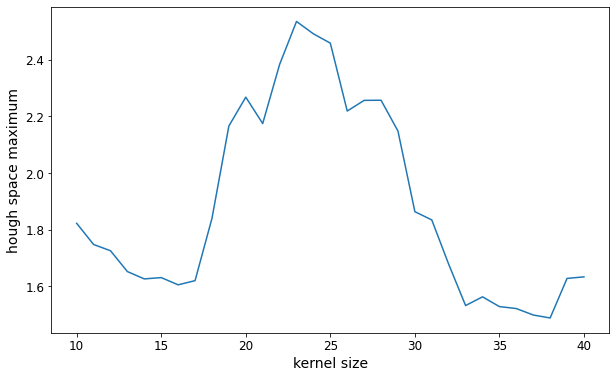

In [19]:
x = np.arange(START_KERNEL_SIZE, END_KERNEL_SIZE + 1)
y = [np.max(hough_space[i]) for i in range(END_KERNEL_SIZE - START_KERNEL_SIZE + 1)]
plt.plot(x, y)
plt.xlabel('kernel size')
plt.ylabel('hough space maximum')
plt.savefig(f'plots/hough_space_max_{START_KERNEL_SIZE}_{END_KERNEL_SIZE}')
plt.show()

In [20]:
total_max = np.max(y)
threshold = 0.55 * total_max
filtered_hough_space = tf.keras.activations.relu(hough_space, threshold=threshold)

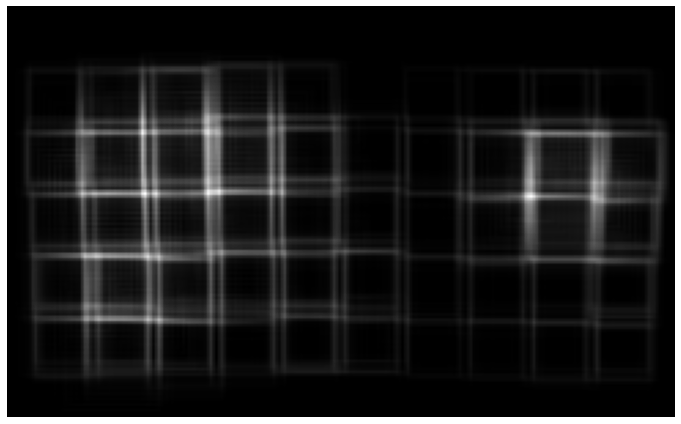

In [21]:
squares = np.zeros(shape=downscaled_edges.shape)
for i, kernel in enumerate(get_square_kernels(START_KERNEL_SIZE, END_KERNEL_SIZE, normalize=False)):
    transpose_conv = tf.keras.layers.Conv2DTranspose(1, kernel.shape,
                                                     strides=(1, 1),
                                                     padding='same',
                                                     kernel_initializer=tf.keras.initializers.Constant(kernel))
    current_squares = transpose_conv(np.array([filtered_hough_space[i]]))[0]
    squares += current_squares
    
show_and_save(squares, 'found_squares')

## 3. Merge

In [22]:
upsampler = tf.keras.layers.UpSampling2D(size=(DOWNSCALING_FACTOR, DOWNSCALING_FACTOR))
upscaled_squares = upsampler(np.array([squares]))[0]
upscaled_squares /= np.max(upscaled_squares)
upscaled_squares.shape

TensorShape([600, 976, 1])

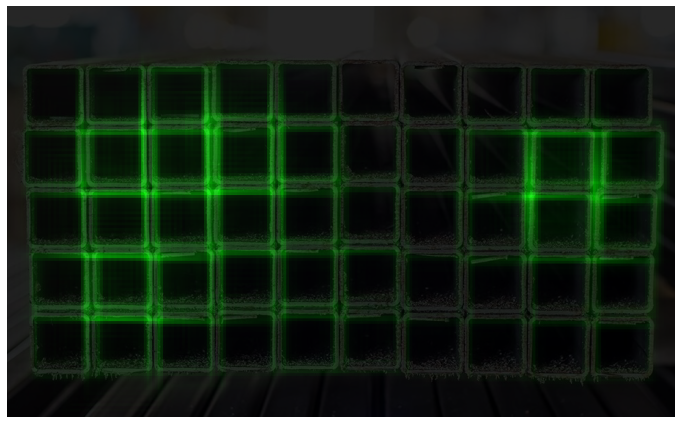

In [23]:
merged_image = copy.deepcopy(image)
merged_image[:, :, 1] *= 0.15
merged_image[:, :, 1] += 0.85 * upscaled_squares[:, :, 0]
merged_image[:, :, 0] *= 0.15
merged_image[:, :, 2] *= 0.15
show_and_save(merged_image, f'merged_image_{image_name}')

## Extra: Normalized hough space max vs size

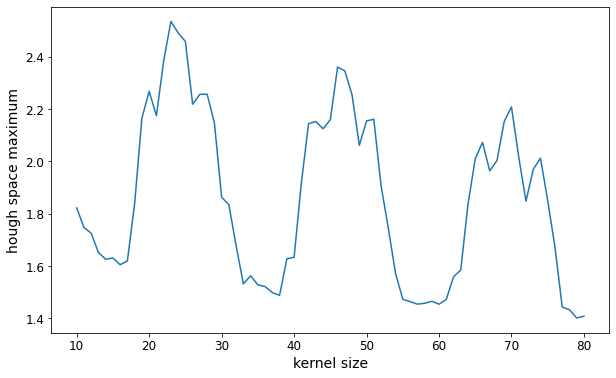

In [24]:
START_KERNEL_SIZE = 40 // DOWNSCALING_FACTOR
END_KERNEL_SIZE = 320 // DOWNSCALING_FACTOR

new_hough_space = []
for kernel in get_square_kernels(START_KERNEL_SIZE, END_KERNEL_SIZE, normalize=True):
    transpose_conv = tf.keras.layers.Conv2DTranspose(1, kernel.shape,
                                                     strides=(1, 1),
                                                     padding='valid',
                                                     kernel_initializer=tf.keras.initializers.Constant(kernel))
    current_hough_space = transpose_conv(np.array([downscaled_edges]))[0]
    new_hough_space += [current_hough_space]
    
x = np.arange(START_KERNEL_SIZE, END_KERNEL_SIZE + 1)
y = [np.max(new_hough_space[i]) for i in range(END_KERNEL_SIZE - START_KERNEL_SIZE + 1)]
plt.plot(x, y)
plt.xlabel('kernel size')
plt.ylabel('hough space maximum')
plt.savefig(f'plots/hough_space_max_{START_KERNEL_SIZE}_{END_KERNEL_SIZE}')
plt.show()